In [1]:
# Dependencies
import os
import pandas as pd
from citipy import citipy
import numpy as np
from pprint import pprint
from config import api_key
import matplotlib.pyplot as plt
import json
import requests
import datetime as dt

## Create a list of cities

In [2]:
# Create a random list of latitudes and longitudes
# np.random.uniform makes sure that all the numbers in the range get equal chance of getting picked

latitudes = np.random.uniform(-90, 90, size = 2000) # 500 random numbers from -90 to 90 deg latitude
longitudes = np.random.uniform(-180, 180, size = 2000) # 500 random numbers from -180 to 180 deg longitude

coordinates = list(zip(latitudes, longitudes))

In [3]:
# Nearby cities per latitude-longitude pair
cities = []

for coord in coordinates:
    lat, lon = coord
    cities.append(citipy.nearest_city(lat, lon))

In [4]:
# Set of cities
city_names = []
country = []

for city in cities:
    city_names.append(city.city_name) # loop through the city coordinates to get the city names
    country.append(city.country_code) # loop through the city coordinates to get the city names
    
city_dict ={
    "city": city_names,
    "country": country,
    "latitude": latitudes,
    "longitude": longitudes
           }    

city_df = pd.DataFrame(city_dict)
city_df = city_df.drop_duplicates(["city","country"]) # drop city-country duplicates
city_df = city_df.dropna() # drop rows with missing values

In [5]:
# Add new columns
city_df["Temperature (F)"] = ""
city_df["Humidity (%)"] = ""
city_df["Cloudiness (%)"] = ""
city_df["Wind Speed (mph)"] = ""
city_df.head()

,city,country,latitude,longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,hermanus,za,-76.566748,11.242496,,,,
1,khatanga,ru,85.734943,103.876858,,,,
2,ushuaia,ar,-73.803343,-20.703691,,,,
4,ketchenery,ru,47.541362,44.408472,,,,
6,cap malheureux,mu,-17.616833,56.671015,,,,


In [6]:
# Get JSON file containing city ID
filepath = os.path.join("Resources","city.list.json")
with open(filepath) as json_file:
    json_data = json.load(json_file)

In [7]:
# Get the city name, country code, and city ID 
# City IDs are more reliable because they are unique identifiers; there could be cities with the same name but in different countries

ct_name = []
co_name = []
ct_ID = []

for i in json_data:
    ct_name.append(i["name"]) # city name from JSON file
    co_name.append(i["country"]) # country name from JSON file
    ct_ID.append(i["id"]) # city ID from JSON file

In [8]:
# Put the JSON-sourced data into a dataframe
json_dict = {
    "city": ct_name,
    "country": co_name,
    "city ID": ct_ID}

json_df = pd.DataFrame(json_dict)
json_df["city"] = json_df["city"].str.lower() # make the letters lowercase
json_df["country"] = json_df["country"].str.lower() # make the letters lowercase
json_df.head()

,city,country,city ID
0,hurzuf,ua,707860
1,novinki,ru,519188
2,gorkhā,np,1283378
3,state of haryāna,in,1270260
4,holubynka,ua,708546


In [9]:
# Merge json_df and city_df
city_df2 = pd.merge(city_df,json_df, on = ["city", "country"])
city_df2 = city_df2.drop_duplicates(["city", "country"])
print(f"There are {len(city_df2)} cities in this dataframe.")
city_df2.head()

There are 653 cities in this dataframe.


,city,country,latitude,longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),city ID
0,hermanus,za,-76.566748,11.242496,,,,,3366880
1,khatanga,ru,85.734943,103.876858,,,,,2022572
2,ushuaia,ar,-73.803343,-20.703691,,,,,3833367
3,cap malheureux,mu,-17.616833,56.671015,,,,,934649
4,bengkulu,id,-12.731158,97.703446,,,,,1649150


## Get the weather for each city through the OpenWeatherData API

In [10]:
# Formulate the query URL
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Loop through the rows to get the different cities and countries
for index, row in city_df2.iterrows():
    x = row["city"]
    y = row["country"]
    
    # Create a variable for iteration through the dataframe
    city_ID = row["city ID"]
    
    # Create a query URL
    query_url = f"{url}&appid={api_key}&id={city_ID}&units={units}"
    
    # Create a request and JSON-ify
    print(f"Retrieving information for Index {index}: {x},{y} (ID: {city_ID}).")
    response = requests.get(query_url)
    response_json = response.json()
    
    # Extract response
    try:
        print(f"{x},{y} (ID: {city_ID}) has {response_json['clouds']['all']}% cloudiness.")
        
        city_df2.loc[index, "Cloudiness (%)"] = response_json["clouds"]["all"]
        city_df2.loc[index, "Humidity (%)"] = response_json["main"]["humidity"]
        city_df2.loc[index, "Wind Speed (mph)"] = response_json["wind"]["speed"]
        city_df2.loc[index, "Temperature (F)"] = response_json["main"]["temp"]
    
    except (KeyError, IndexError):
        print("The city is not on the list. It will rain meatballs!")
    
    print("----------")

Retrieving information for Index 0: hermanus,za (ID: 3366880).
hermanus,za (ID: 3366880) has 0% cloudiness.
----------
Retrieving information for Index 1: khatanga,ru (ID: 2022572).
khatanga,ru (ID: 2022572) has 56% cloudiness.
----------
Retrieving information for Index 2: ushuaia,ar (ID: 3833367).
ushuaia,ar (ID: 3833367) has 75% cloudiness.
----------
Retrieving information for Index 3: cap malheureux,mu (ID: 934649).
cap malheureux,mu (ID: 934649) has 20% cloudiness.
----------
Retrieving information for Index 4: bengkulu,id (ID: 1649150).
bengkulu,id (ID: 1649150) has 92% cloudiness.
----------
Retrieving information for Index 5: ariquemes,br (ID: 3665199).
ariquemes,br (ID: 3665199) has 12% cloudiness.
----------
Retrieving information for Index 6: antalaha,mg (ID: 1071296).
antalaha,mg (ID: 1071296) has 12% cloudiness.
----------
Retrieving information for Index 7: deputatskiy,ru (ID: 2028164).
deputatskiy,ru (ID: 2028164) has 8% cloudiness.
----------
Retrieving information for

inta,ru (ID: 1505579) has 68% cloudiness.
----------
Retrieving information for Index 89: necochea,ar (ID: 3430443).
necochea,ar (ID: 3430443) has 0% cloudiness.
----------
Retrieving information for Index 90: ocos,gt (ID: 3592086).
ocos,gt (ID: 3592086) has 75% cloudiness.
----------
Retrieving information for Index 91: yellowknife,ca (ID: 6185377).
yellowknife,ca (ID: 6185377) has 75% cloudiness.
----------
Retrieving information for Index 92: husavik,is (ID: 2629833).
husavik,is (ID: 2629833) has 20% cloudiness.
----------
Retrieving information for Index 93: torbay,ca (ID: 6167817).
torbay,ca (ID: 6167817) has 90% cloudiness.
----------
Retrieving information for Index 94: bluff,nz (ID: 2206939).
bluff,nz (ID: 2206939) has 0% cloudiness.
----------
Retrieving information for Index 95: vernon,us (ID: 4095392).
vernon,us (ID: 4095392) has 75% cloudiness.
----------
Retrieving information for Index 98: kununurra,au (ID: 2068110).
kununurra,au (ID: 2068110) has 44% cloudiness.
--------

madaoua,ne (ID: 2441530) has 8% cloudiness.
----------
Retrieving information for Index 178: portland,au (ID: 2152667).
portland,au (ID: 2152667) has 92% cloudiness.
----------
Retrieving information for Index 180: vostok,ru (ID: 2013279).
vostok,ru (ID: 2013279) has 32% cloudiness.
----------
Retrieving information for Index 182: laguna beach,us (ID: 5364275).
laguna beach,us (ID: 5364275) has 90% cloudiness.
----------
Retrieving information for Index 184: tanout,ne (ID: 2439155).
tanout,ne (ID: 2439155) has 0% cloudiness.
----------
Retrieving information for Index 185: khorramshahr,ir (ID: 127319).
khorramshahr,ir (ID: 127319) has 24% cloudiness.
----------
Retrieving information for Index 186: salalah,om (ID: 286621).
salalah,om (ID: 286621) has 90% cloudiness.
----------
Retrieving information for Index 187: san fernando,mx (ID: 3483197).
san fernando,mx (ID: 3483197) has 0% cloudiness.
----------
Retrieving information for Index 189: atuona,pf (ID: 4020109).
atuona,pf (ID: 40201

port keats,au (ID: 2063039) has 8% cloudiness.
----------
Retrieving information for Index 256: guayaramerin,bo (ID: 3915350).
guayaramerin,bo (ID: 3915350) has 0% cloudiness.
----------
Retrieving information for Index 257: xianyang,cn (ID: 1790353).
xianyang,cn (ID: 1790353) has 76% cloudiness.
----------
Retrieving information for Index 259: adrar,dz (ID: 2508813).
adrar,dz (ID: 2508813) has 0% cloudiness.
----------
Retrieving information for Index 260: yerkoy,tr (ID: 296895).
yerkoy,tr (ID: 296895) has 20% cloudiness.
----------
Retrieving information for Index 261: tobane,bw (ID: 933002).
tobane,bw (ID: 933002) has 90% cloudiness.
----------
Retrieving information for Index 262: lac du bonnet,ca (ID: 6014443).
lac du bonnet,ca (ID: 6014443) has 12% cloudiness.
----------
Retrieving information for Index 263: tonantins,br (ID: 3661894).
tonantins,br (ID: 3661894) has 24% cloudiness.
----------
Retrieving information for Index 264: kaa-khem,ru (ID: 1505187).
kaa-khem,ru (ID: 150518

lovozero,ru (ID: 533933) has 92% cloudiness.
----------
Retrieving information for Index 347: kadyy,ru (ID: 554502).
kadyy,ru (ID: 554502) has 92% cloudiness.
----------
Retrieving information for Index 348: port elizabeth,za (ID: 964420).
port elizabeth,za (ID: 964420) has 20% cloudiness.
----------
Retrieving information for Index 349: florida,uy (ID: 3442585).
florida,uy (ID: 3442585) has 0% cloudiness.
----------
Retrieving information for Index 350: maroantsetra,mg (ID: 1060283).
maroantsetra,mg (ID: 1060283) has 92% cloudiness.
----------
Retrieving information for Index 351: dingle,ie (ID: 2964782).
dingle,ie (ID: 2964782) has 12% cloudiness.
----------
Retrieving information for Index 352: kyzyl,ru (ID: 1500973).
kyzyl,ru (ID: 1500973) has 88% cloudiness.
----------
Retrieving information for Index 353: cepu,id (ID: 1647179).
cepu,id (ID: 1647179) has 92% cloudiness.
----------
Retrieving information for Index 355: charters towers,au (ID: 7839570).
charters towers,au (ID: 78395

besikduzu,tr (ID: 750735) has 75% cloudiness.
----------
Retrieving information for Index 434: katsuura,jp (ID: 2112309).
katsuura,jp (ID: 2112309) has 75% cloudiness.
----------
Retrieving information for Index 435: vao,nc (ID: 2137773).
vao,nc (ID: 2137773) has 64% cloudiness.
----------
Retrieving information for Index 436: patacamaya,bo (ID: 3908339).
patacamaya,bo (ID: 3908339) has 76% cloudiness.
----------
Retrieving information for Index 437: leatherhead,gb (ID: 2644726).
leatherhead,gb (ID: 2644726) has 75% cloudiness.
----------
Retrieving information for Index 438: saint-francois,gp (ID: 3578441).
saint-francois,gp (ID: 3578441) has 75% cloudiness.
----------
Retrieving information for Index 439: grand-santi,gf (ID: 3381538).
grand-santi,gf (ID: 3381538) has 0% cloudiness.
----------
Retrieving information for Index 440: muros,es (ID: 6357322).
muros,es (ID: 6357322) has 75% cloudiness.
----------
Retrieving information for Index 442: wenzhou,cn (ID: 1791388).
wenzhou,cn (ID

staryy nadym,ru (ID: 1490918) has 88% cloudiness.
----------
Retrieving information for Index 515: brownsville,us (ID: 5234282).
brownsville,us (ID: 5234282) has 75% cloudiness.
----------
Retrieving information for Index 523: auki,sb (ID: 2109701).
auki,sb (ID: 2109701) has 76% cloudiness.
----------
Retrieving information for Index 524: carthage,us (ID: 4886716).
carthage,us (ID: 4886716) has 40% cloudiness.
----------
Retrieving information for Index 532: nowy sacz,pl (ID: 763534).
nowy sacz,pl (ID: 763534) has 0% cloudiness.
----------
Retrieving information for Index 533: waycross,us (ID: 4229763).
waycross,us (ID: 4229763) has 1% cloudiness.
----------
Retrieving information for Index 534: micheweni,tz (ID: 153955).
micheweni,tz (ID: 153955) has 64% cloudiness.
----------
Retrieving information for Index 535: dunedin,nz (ID: 2191562).
dunedin,nz (ID: 2191562) has 0% cloudiness.
----------
Retrieving information for Index 536: luganville,vu (ID: 2136150).
luganville,vu (ID: 213615

montevideo,uy (ID: 3441575) has 0% cloudiness.
----------
Retrieving information for Index 620: jian,cn (ID: 1806445).
jian,cn (ID: 1806445) has 92% cloudiness.
----------
Retrieving information for Index 622: mandan,us (ID: 5690366).
mandan,us (ID: 5690366) has 80% cloudiness.
----------
Retrieving information for Index 623: srivardhan,in (ID: 1255619).
srivardhan,in (ID: 1255619) has 12% cloudiness.
----------
Retrieving information for Index 624: haines junction,ca (ID: 5969025).
haines junction,ca (ID: 5969025) has 92% cloudiness.
----------
Retrieving information for Index 625: celestun,mx (ID: 3531368).
celestun,mx (ID: 3531368) has 0% cloudiness.
----------
Retrieving information for Index 626: mount isa,au (ID: 2065594).
mount isa,au (ID: 2065594) has 0% cloudiness.
----------
Retrieving information for Index 628: izumo,jp (ID: 1861084).
izumo,jp (ID: 1861084) has 75% cloudiness.
----------
Retrieving information for Index 629: pacific grove,us (ID: 5380437).
pacific grove,us (

flinders,au (ID: 2166453) has 12% cloudiness.
----------
Retrieving information for Index 711: heihe,cn (ID: 2036973).
heihe,cn (ID: 2036973) has 40% cloudiness.
----------
Retrieving information for Index 712: mareeba,au (ID: 2158767).
mareeba,au (ID: 2158767) has 75% cloudiness.
----------
Retrieving information for Index 713: mantua,cu (ID: 3547930).
mantua,cu (ID: 3547930) has 8% cloudiness.
----------
Retrieving information for Index 714: rena,no (ID: 3141982).
rena,no (ID: 3141982) has 44% cloudiness.
----------
Retrieving information for Index 715: zeya,ru (ID: 2012593).
zeya,ru (ID: 2012593) has 56% cloudiness.
----------
Retrieving information for Index 716: elko,us (ID: 5703670).
elko,us (ID: 5703670) has 1% cloudiness.
----------
Retrieving information for Index 717: beloretsk,ru (ID: 577881).
beloretsk,ru (ID: 577881) has 75% cloudiness.
----------
Retrieving information for Index 718: itoman,jp (ID: 1861280).
itoman,jp (ID: 1861280) has 75% cloudiness.
----------
Retrievin

mayo,ca (ID: 6068416) has 90% cloudiness.
----------
Retrieving information for Index 797: bilibino,ru (ID: 2126682).
bilibino,ru (ID: 2126682) has 88% cloudiness.
----------
Retrieving information for Index 798: omboue,ga (ID: 2396853).
omboue,ga (ID: 2396853) has 92% cloudiness.
----------
Retrieving information for Index 799: talara,pe (ID: 3691582).
talara,pe (ID: 3691582) has 80% cloudiness.
----------
Retrieving information for Index 800: camacha,pt (ID: 2270385).
camacha,pt (ID: 2270385) has 40% cloudiness.
----------
Retrieving information for Index 802: camana,pe (ID: 3945985).
camana,pe (ID: 3945985) has 92% cloudiness.
----------
Retrieving information for Index 803: horsham,au (ID: 7839554).
horsham,au (ID: 7839554) has 92% cloudiness.
----------
Retrieving information for Index 805: trofors,no (ID: 3133983).
trofors,no (ID: 3133983) has 75% cloudiness.
----------
Retrieving information for Index 806: provideniya,ru (ID: 4031574).
provideniya,ru (ID: 4031574) has 32% cloudi

In [26]:
# Get the date today for the file date-stamp
today = dt.datetime.today().strftime('%Y%m%d')

# save the dataframe as a csv file 
city_df2.to_csv('weather_output_{}.csv'.format(today), index = False, encoding = 'utf-8')

# Preview the dataframe
city_df2.head()

,city,country,latitude,longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),city ID
0,hermanus,za,-76.566748,11.242496,73.18,40,0,11.23,3366880
1,khatanga,ru,85.734943,103.876858,24.04,78,56,5.75,2022572
2,ushuaia,ar,-73.803343,-20.703691,35.6,80,75,27.51,3833367
3,cap malheureux,mu,-17.616833,56.671015,78.8,57,20,11.41,934649
4,bengkulu,id,-12.731158,97.703446,79.57,100,92,4.18,1649150


## Create scatterplots

In [12]:
# Choose ggplot as style for plots
plt.style.use('ggplot')

# Size of plots
fig_size = plt.rcParams["figure.figsize"] # get current size
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size # customise plot size

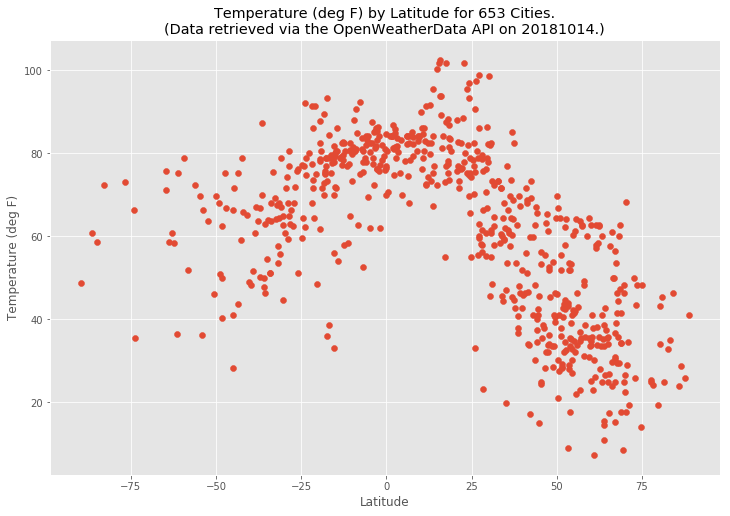

In [42]:
# Latitude vs Temperature
plt.scatter(city_df2["latitude"], city_df2["Temperature (F)"])
plt.xlabel("Latitude")
plt.ylabel("Temperature (deg F)")
plt.title(f"Temperature (deg F) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_temp_{}.png".format(today))
plt.show()

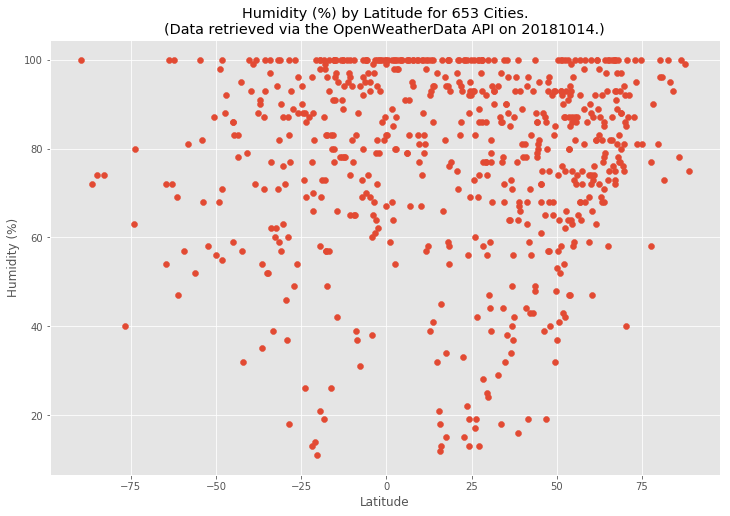

In [43]:
# Latitude vs Humidity
plt.scatter(city_df2["latitude"], city_df2["Humidity (%)"])
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Humidity (%) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_hum_{}.png".format(today))
plt.show()

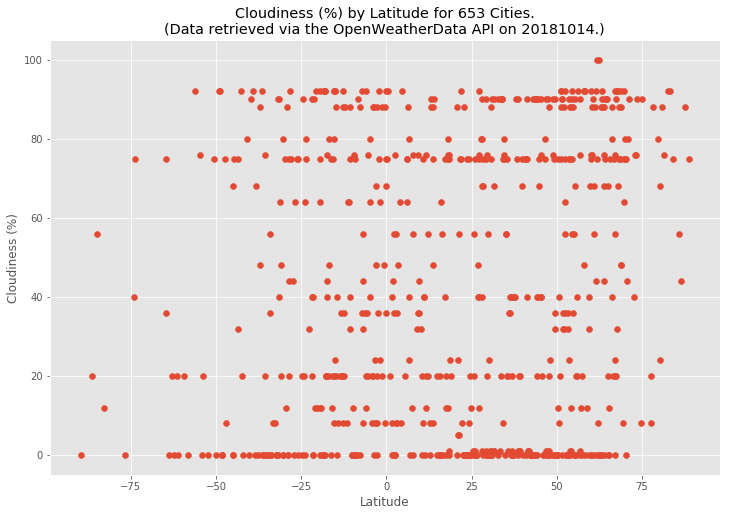

In [44]:
# Latitude vs Cloudiness
plt.scatter(city_df2["latitude"], city_df2["Cloudiness (%)"])
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"Cloudiness (%) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_cloud_{}.png".format(today))
plt.show()

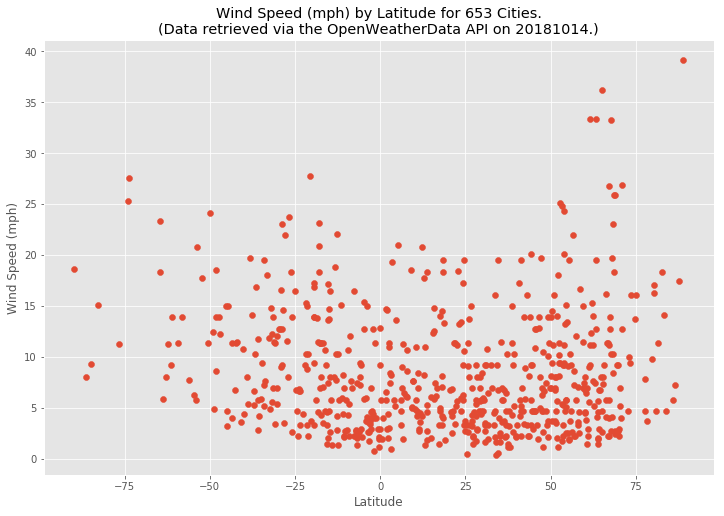

In [46]:
# Latitude vs Wind Speed
plt.scatter(city_df2["latitude"], city_df2["Wind Speed (mph)"])
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_wind_{}.png".format(today))
plt.show()

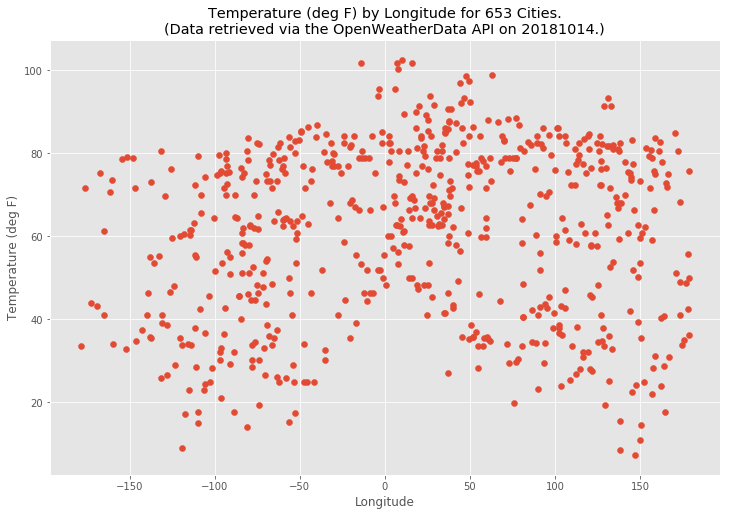

In [47]:
# Longitude vs Temperature
plt.scatter(city_df2["longitude"], city_df2["Temperature (F)"])
plt.xlabel("Longitude")
plt.ylabel("Temperature (deg F)")
plt.title(f"Temperature (deg F) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_temp_{}.png".format(today))
plt.show()

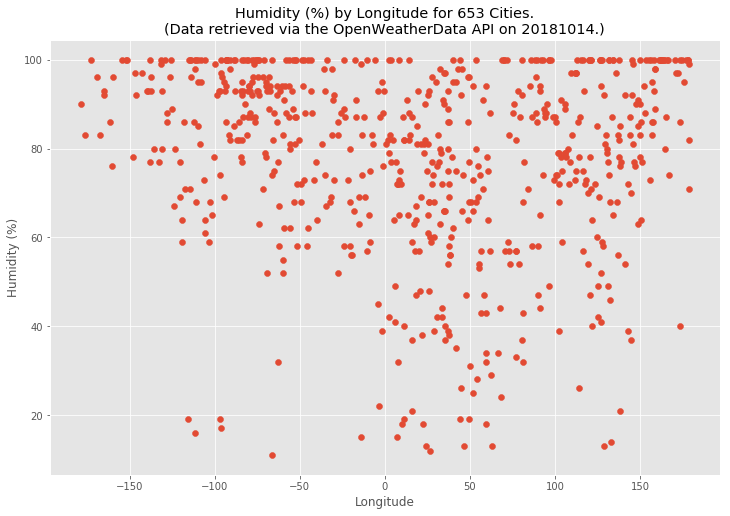

In [49]:
# Longitude vs Humidity
plt.scatter(city_df2["longitude"], city_df2["Humidity (%)"])
plt.xlabel("Longitude")
plt.ylabel("Humidity (%)")
plt.title(f"Humidity (%) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_hum_{}.png".format(today))
plt.show()

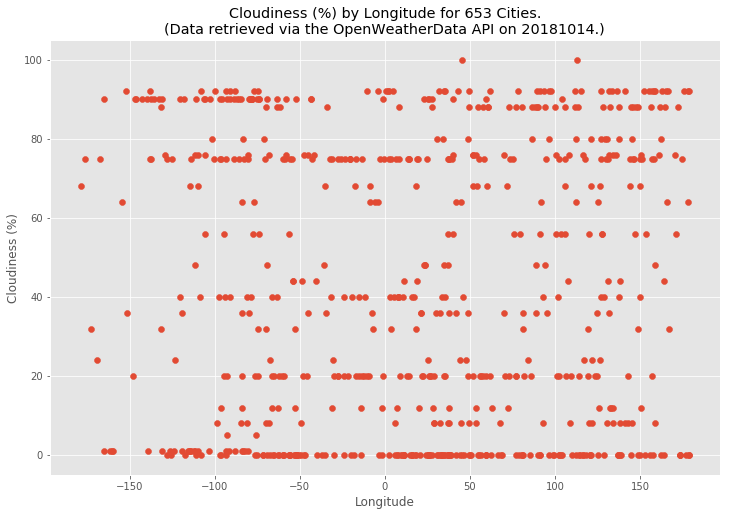

In [50]:
# Longitude vs Cloudiness
plt.scatter(city_df2["longitude"], city_df2["Cloudiness (%)"])
plt.xlabel("Longitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"Cloudiness (%) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_cloud_{}.png".format(today))
plt.show()

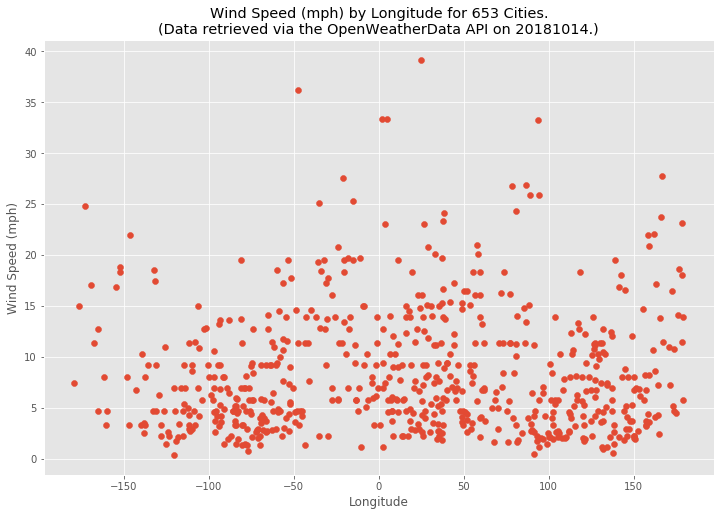

In [51]:
# Longitude vs Wind Speed
plt.scatter(city_df2["longitude"], city_df2["Wind Speed (mph)"])
plt.xlabel("Longitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_wind_{}.png".format(today))
plt.show()

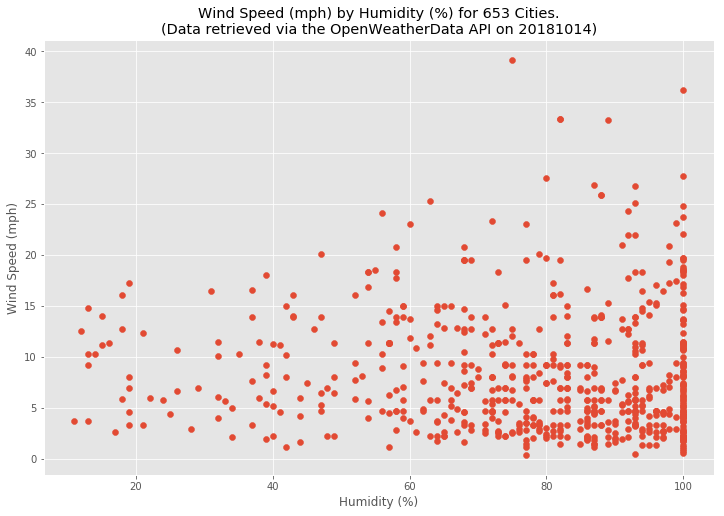

In [52]:
# Humidity vs Wind Speed
plt.scatter(city_df2["Humidity (%)"], city_df2["Wind Speed (mph)"])
plt.xlabel("Humidity (%)")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Humidity (%) for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today})")

# Save image
plt.savefig("Images/hum_wind_{}.png".format(today))
plt.show()

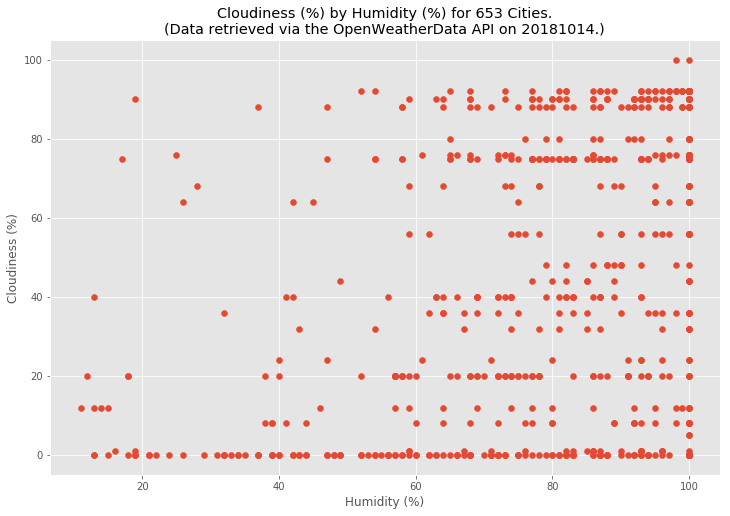

In [54]:
# Humidity vs Cloudiness
plt.scatter(city_df2["Humidity (%)"], city_df2["Cloudiness (%)"])
plt.xlabel("Humidity (%)")
plt.ylabel("Cloudiness (%)")
plt.title(f"Cloudiness (%) by Humidity (%) for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/hum_cloud_{}.png".format(today))
plt.show()

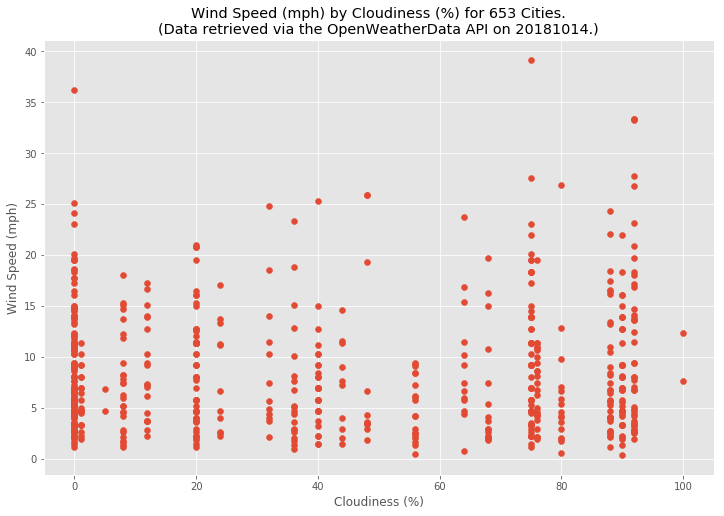

In [55]:
# Humidity vs Wind Speed
plt.scatter(city_df2["Cloudiness (%)"], city_df2["Wind Speed (mph)"])
plt.xlabel("Cloudiness (%)")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Cloudiness (%) for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/cloud_wind_{}.png".format(today))
plt.show()